# Bayesian NN with Laplace Approximations - Multi-class

The goal of this notebook is to showcase that we can get a better uncertainty quantification via a simple last-layer approximate Bayesian technique. The idea of the method used is as follows: Suppose we have an $L$-layer MAP-trained (deep) ReLU network, we apply a Laplace approximation at **only** the last-layer of the network. That is, the first $L-1$ layers are treated as a fixed feature map $\phi$ and the last-layer is treated as a Bayesian softmax regression with a matrix-Gaussian [1] posterior $\mathcal{MN}(W^L \mid M, U, V) \iff \mathcal{N}(\mathrm{vec}(W^L) \mid \mathrm{vec}(M), V \otimes U)$. Since we use a Laplace approximation, we set $\mu := W^L_\text{MAP}$ and $U, V$ to be the Kronecker-factors of the Hessian of the log-posterior. More details will be discussed when we see the actual Laplace approximation code.


**References**

1. https://en.wikipedia.org/wiki/Matrix_normal_distribution

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

First, we create a toy 4-class classification dataset $D$.

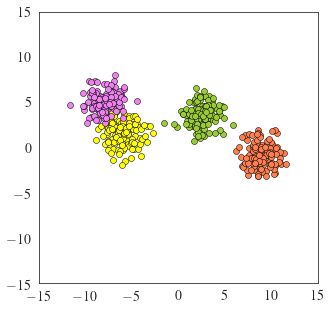

In [2]:
np.random.seed(7777)
size = 500
train_range = (-10, 10)

X, Y = datasets.make_blobs(n_samples=size, centers=4, cluster_std=1.2, 
                           center_box=train_range, random_state=37)

test_range = (-15, 15)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='violet', edgecolors='k', linewidths=0.5)
plt.xlim(test_range);
plt.ylim(test_range);

We will use a three-layer ReLU network and train it using maximum likelihood with weight decay. Note that the weight decay strength can be seen as the Gaussian prior's precision. This is a crucial bit of information for doing the Laplace approximation later on.

In [3]:
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.043


Here's a plotting function to visualize our results.

In [4]:
def plot(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.3, 1.01, 0.1))
    plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.show();

And here's a test dataset, which is just evenly-spaced points in some region of the domain, since we want to predict the confidence of the whole region.

In [5]:
# Test data
size = 50
test_range = (-15, 15)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()

This is the confidence plot (defined as the maximum probability of each prediction) of the model. This is what we are familiar with and use all the time in deep learning. Notice how the confidence is high (close to one) almost everywhere. Do you think this is a good prediction? Why or why not?

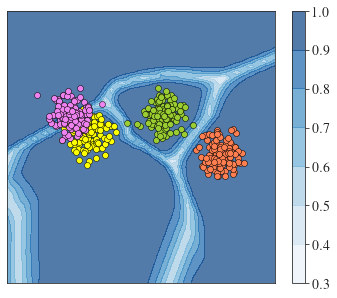

In [6]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

Now, let's see whether we can incorporate the model's uncertainty into the prediction. That is, we want to infer the posterior, and use it to marginalize the prediction:

$$
    p(y = 1 \mid x) = \int \mathrm{softmax}(f_\theta(x)) \, p(\theta \mid D) \, d\theta \, , 
$$

where $f_\theta$ is our ReLU network.

One simple way to do this is by doing a Laplace approximation: We approximate the posterior as $\mathcal{N}(\mathrm{vec}(\theta) \mid \mathrm{vec}(\theta_\text{MAP}), H^{-1})$ where $\theta_\text{MAP}$ is the trained weights and $H := -\nabla^2_\theta \log p(\theta \mid D)$ is the Hessian of the negative log-posterior.

However, notice that if the network is large (has many parameters), then $H$ is huge since it scales quadratically to the number of parameters for each class. Here, we make another simplifying assumption: We only apply the Laplace approximation at the _last-layer_. Assume that $\phi$ is the first $L-1$ layers of the network and $W^L$ is the last-layer's weight vector. Then, the prediction is given by:

$$
    p(y = 1 \mid x) \approx \int \mathrm{softmax}({W^L} \phi(x)) \, \mathcal{N}(\mathrm{vec}(W^L) \mid \mathrm{vec}(W^L_\text{MAP}), \Sigma) \, dW^L \, ,
$$

where $\Sigma = (-\nabla^2_{W^L} \log p(\theta \mid D))^{-1}$ is the inverse of the particular sub-matrix of $H$ corresponding to the Hessian of the last-layer.

This might still be an issue if the network is large and the number of classes is also large, since the Hessian would be a $PK \times PK$ matrix where $P$ is the number of parameters and $K$ is the number of classes. We therefore approximate this further by assuming that it can be Kronecker-factored: $H \approx V \otimes U$. One can use K-FAC [2] for doing this and the resulting model is called the Kronecker-factored Laplace Approximation (KFLA) [3]. One can easily use BackPACK package [5] for this.

Finally, since the integral above is intractable, even with our approximations, we need to do Monte Carlo integration. First, using the properties of matrix Gaussian, we can show that the distribution over the pre-softmax outputs is given by

$$
    p({W^L} \phi(x) \mid W^L, x) = \mathcal{N}({W^L} \phi(x) \mid {W^L_\text{MAP}} \phi(x), (x^\top V x)U) \, ,
$$

which is just a $K$-variate Gaussian. Sampling this distribution is easy and lightweight, so the MC-integral is relatively fast.


**References**

2. Heskes, Tom. "On “natural” learning and pruning in multilayered perceptrons." Neural Computation 12.4 (2000): 881-901.
3. Martens, James, and Roger Grosse. "Optimizing neural networks with kronecker-factored approximate curvature." International conference on machine learning. 2015.
4. Ritter, Hippolyt, Aleksandar Botev, and David Barber. "A scalable laplace approximation for neural networks." 6th International Conference on Learning Representations, ICLR 2018-Conference Track Proceedings. Vol. 6. International Conference on Representation Learning, 2018.
5. Dangel, Felix, Frederik Kunstner, and Philipp Hennig. "BackPACK: Packing more into backprop." ICLR 2020.

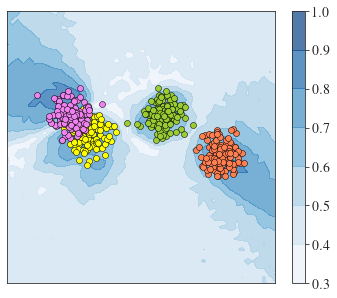

In [7]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
prec0 = 5e-4

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))


@torch.no_grad()
def predict(x):
    phi = model.feature_extr(x)
    
    # MAP prediction
    m = phi @ W.T
    
    # v is the induced covariance. 
    # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
    v = torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U
        
    # The induced distribution over the output (pre-softmax)
    output_dist = MultivariateNormal(m, v)

    # MC-integral
    n_sample = 1000
    py = 0

    for _ in range(n_sample):
        out_s = output_dist.rsample()
        py += torch.softmax(out_s, 1)

    py /= n_sample

    return py.numpy()


# Get the posterior covariance and make prediction
py = predict(X_test)

# Confidence
conf = py.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)